In [4]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft
import os

In [62]:
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)
    cap.release()
    return frames

def save_frames(frames, folder_path):
    for i, frame in enumerate(frames):
        cv2.imwrite(os.path.join(folder_path, f'frame_{i}.png'), frame)

def rgb_to_hsv(r, g, b):
    rgb = np.uint8([[[r, g, b]]])
    hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    return hsv[0][0]

def create_hsv_bounds(h, s, v, tolerance=0.15):
    lower_bound = np.array([h - (180 * tolerance), max(0, s - (255 * tolerance)), max(0, v - (255 * tolerance))])
    upper_bound = np.array([h + (180 * tolerance), min(255, s + (255 * tolerance)), min(255, v + (255 * tolerance))])
    return lower_bound, upper_bound




In [6]:
def get_red_centroid_threshold(frame, tolerance):
    red_centroids = []
    # Convert the frame to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Define the lower and upper bounds for the red color
    red_color = (200, 142, 143)
    red_hsv = rgb_to_hsv(*red_color)
    lower_red, upper_red = create_hsv_bounds(*red_hsv,tolerance=tolerance)

    # Threshold the HSV image to get only red colors
    mask = cv2.inRange(hsv, lower_red, upper_red)


    # Find contours in the mask
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Find the largest contour
        c = max(contours, key=cv2.contourArea)

        # Find the centroid of the largest contour
        M = cv2.moments(c)
        if M["m00"] != 0:  # check for division by zero
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            red_centroids.append((cx, cy))
            
            # Draw a circle on the frame at the centroid
            marked_frame = cv2.circle(frame.copy(), (cx, cy), 15, (0, 255, 0), 3)
            return red_centroids, marked_frame

    return red_centroids, frame  # Return original frame if no red found


def get_features(frame):
    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and compute the descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)

    return keypoints, descriptors

def match_features(descriptors1, descriptors2):
    # Initialize the BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Match descriptors from the first frame and the next frame
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches based on distance. Best matches come first
    matches = sorted(matches, key=lambda x: x.distance)

    return matches


In [7]:
def get_features_near_centroid(frame, centroid, max_distance=3):
    # Initialize the ORB detector
    orb = cv2.ORB_create()

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect keypoints and compute the descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)

    # Keep only the keypoints (and their descriptors) that are within max_distance from the centroid
    keypoints_near_centroid = []
    descriptors_near_centroid = []
    for i, keypoint in enumerate(keypoints):
        distance = np.sqrt((keypoint.pt[0] - centroid[0][0])**2 + (keypoint.pt[1] - centroid[0][1])**2)
        if distance <= max_distance:
            keypoints_near_centroid.append(keypoint)
            descriptors_near_centroid.append(descriptors[i])

    return keypoints_near_centroid, np.array(descriptors_near_centroid)


In [8]:
def compute_centroid_of_keypoints(keypoints):
    if not keypoints:
        return None

    total_x = sum(keypoint.pt[0] for keypoint in keypoints)
    total_y = sum(keypoint.pt[1] for keypoint in keypoints)

    centroid_x = total_x / len(keypoints)
    centroid_y = total_y / len(keypoints)

    return (centroid_x, centroid_y)



In [9]:
#for kepoints ORB detection 
def process_video_augmentation(video_path, output_folder):
    # Extract frames from the video
    frames = extract_frames(video_path)

    # If it doesn't exist, create the output folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    marked_frames = []
    previous_descriptors = None
    previous_keypoints = None
    for i, frame in enumerate(frames):
        centroid, marked_frame = get_red_centroid_thresold(frame, tolerance=0.2)
        if centroid:
            # Get features from the frame near the centroid
            keypoints, descriptors = get_features_near_centroid(frame, centroid)

            if i > 0 and previous_descriptors is not None and descriptors.size != 0:
                matches = match_features(previous_descriptors, descriptors)

                # Draw the matches on the frame
                matched_image = cv2.drawMatches(frames[i-1], previous_keypoints, frame, keypoints, matches[:10], None, flags=2)
                marked_frames.append(matched_image)

            previous_descriptors = descriptors if descriptors.size != 0 else None
            previous_keypoints = keypoints if descriptors.size != 0 else None

    # Save the marked frames to the output folder
    save_frames(marked_frames, output_folder)


In [10]:
def compute_moving_average_centroid_of_keypoints(keypoints, previous_centroids, N):
    centroid = compute_centroid_of_keypoints(keypoints)
    if centroid is not None:
        previous_centroids.append(centroid)
        if len(previous_centroids) > N:
            previous_centroids.pop(0)

        # Compute the moving average of the last N centroids
        moving_average_centroid = np.mean(previous_centroids, axis=0)
        return moving_average_centroid, previous_centroids

    return None, previous_centroids



In [11]:
def process_video(video_path, output_folder):
    # Extract frames from the video
    print("Extracting frames from the video...")
    frames = extract_frames(video_path)

    # If it doesn't exist, create the output folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    #smoothing 
    #filtered_centroid = None
    #alpha = 0.1  # adjust this value as needed
    
    new_centroid_frames = []
    new_centroids = []
    previous_descriptors = None
    previous_keypoints = None
    for i, frame in enumerate(frames):
        #print(f"Processing frame {i+1}/{len(frames)}...")

        centroid, marked_frame = get_red_centroid_threshold(frame, tolerance=0.2)
        if centroid:
            print("  Getting features near the red centroid...")
            keypoints, descriptors = get_features_near_centroid(frame, centroid)
            
            print("  Computing new centroid from the keypoints + moving average ...")
            
            new_centroid = compute_centroid_of_keypoints(keypoints)
            
            
            if new_centroid is not None:
                new_centroids.append(new_centroid)
                
                print(f"  New centroid found at {new_centroid}. Marking it on the frame...")
                new_centroid_frame = cv2.circle(frame.copy(), (int(new_centroid[0]), int(new_centroid[1])), 15, (255, 0, 0), 3)
                new_centroid_frames.append(new_centroid_frame)

            if i > 0 and previous_descriptors is not None and descriptors.size != 0:
                print("  Matching features between current and previous frame...")
                matches = match_features(previous_descriptors, descriptors)

            previous_descriptors = descriptors if descriptors.size != 0 else None
            previous_keypoints = keypoints if descriptors.size != 0 else None

    print("Saving the new centroid frames...")
    save_frames(new_centroid_frames, output_folder)

    print("Done.")
    return new_centroids



In [12]:
centroids = process_video('../output_frames/test_Col0_3a_trim.avi','./test_Col0_3a_trim/marker_augmentation')

Extracting frames from the video...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (480.384033203125, 430.27203369140625). Marking it on the frame...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (483.1168263753255, 431.26349385579425). Marking it on the frame...
  Matching feature

In [69]:
len(centroids)

281

In [27]:
def display_saved_images(output_folder, interval=60):
    saved_images = sorted(os.listdir(output_folder))

    for i, img_name in enumerate(saved_images):
        if i % interval == 0:
            img = cv2.imread(os.path.join(output_folder, img_name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert color style from BGR to RGB
            plt.imshow(img)
            plt.title(img_name)
            plt.show()


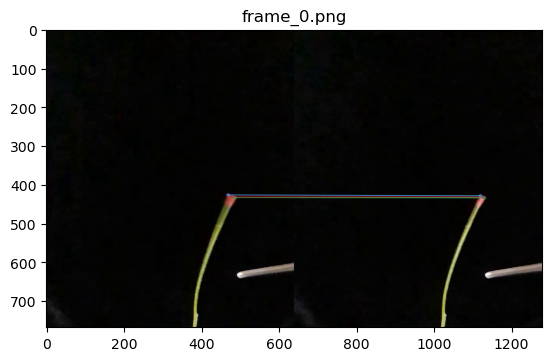

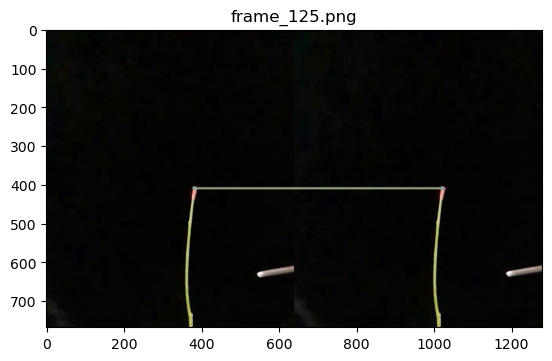

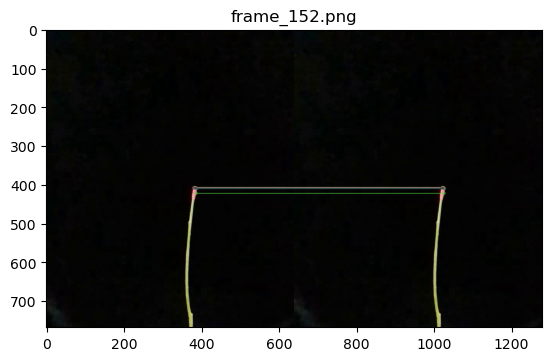

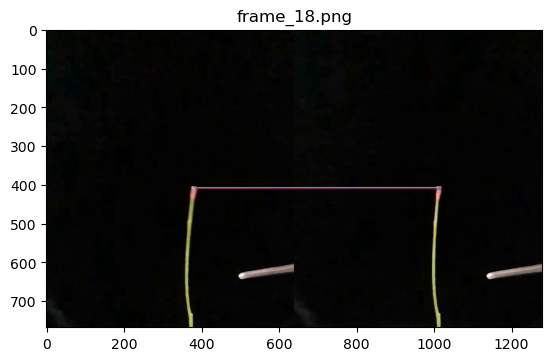

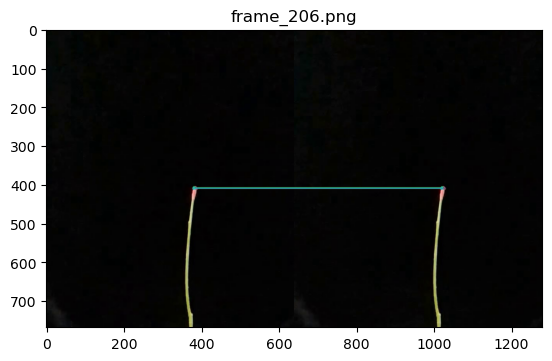

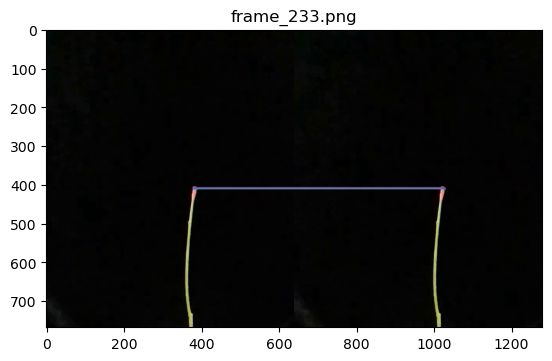

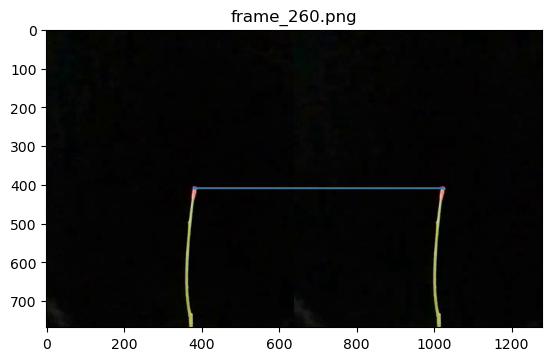

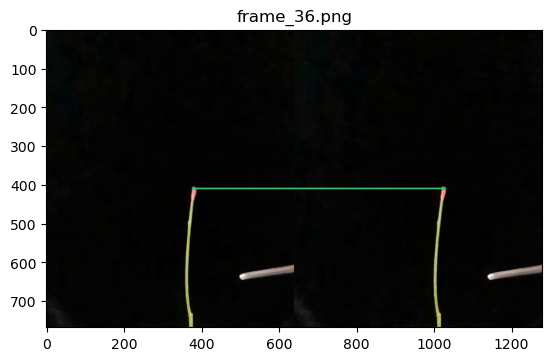

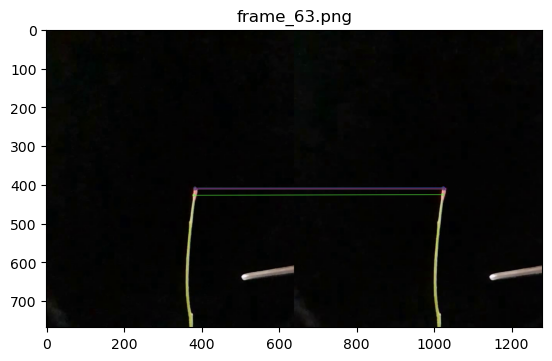

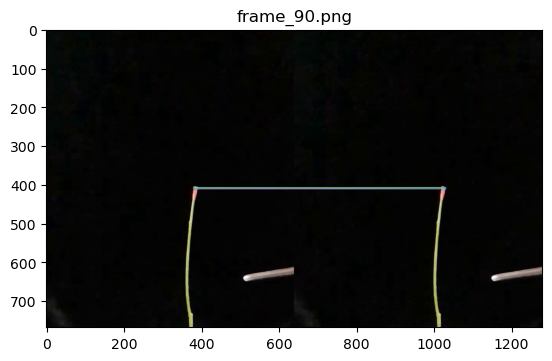

In [30]:
display_saved_images('./test_Col0_3a_trim/data_augmentation')

# Impact of data augmentation 

In [21]:
def nan_processing(array):
    array_copy = array.copy()
    for i,j in [(1,1),(1,2),(2,1),(1,3),(2,2),(3,1),
              (1,4),(4,1),(3,2),(2,3),(1,5),(5,1),(2,4),(4,2),(3,3)]:
        if np.isnan(array_copy).all():
            break
        else:
            array_right = np.roll(array_copy, i, axis=0)
            array_left = np.roll(array_copy, -j, axis=0)
            array_mean = (array_right*j + array_left*i)/(i+j)
            nan_position = np.where(np.isnan(array_copy))
            array_copy[nan_position] = array_mean[nan_position]
    if np.isnan(array_copy[0]).all():
        return array_copy - array_copy[0]
    else:
        return array_copy - np.median(array_copy[:10],axis=0)


def center_to_displacement(center_array):
    displacement_array_0 = np.linalg.norm(center_array, axis=1)
    return np.median(displacement_array_0) - displacement_array_0


def centroids_to_displacements(centroids):
    # Convert centroids to numpy array
    centroids_array = np.array(centroids)

    # Process NaNs
    centroids_filled = nan_processing(centroids_array)

    # Calculate displacements
    displacements = center_to_displacement(centroids_filled)

    return displacements

import matplotlib.pyplot as plt

def plot_displacement(displacements, title):
    t = range(len(displacements))
    
    plt.figure(figsize=(10, 6))
    plt.plot(t, displacements, label='Displacement')
    plt.legend()
    plt.xlabel('Frame number')
    plt.ylabel('Displacement')
    plt.title(f'Displacement over time | {title}')
    plt.grid(True)
    plt.show()

def plot_frequency(frequencies, amplitudes):
    # Only plot for positive frequencies
    mask = frequencies > 0
    freqs = frequencies[mask]
    amps = amplitudes[mask]
    
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, amps, label='Amplitudes')
    plt.legend()
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('Frequencies after FFT')
    plt.grid(True)
    plt.show()

def plot_hanned_displacements(hanned_displacements):
    t = range(len(hanned_displacements))

    plt.figure(figsize=(10, 6))
    plt.plot(t, hanned_displacements, label='Displacement (Hanning Window)')
    plt.title('Displacements after Hanning Window')
    plt.xlabel('Frame number')
    plt.ylabel('Displacement')
    plt.legend()
    plt.grid(True)
    plt.show()


import numpy as np
from scipy import fftpack

def displacement_to_difference(displacement_array):
    displacement_array_copy = displacement_array.copy()
    dif_array = displacement_array_copy - np.roll(displacement_array_copy, -1)
    dif_array = dif_array[:-1]
    start_point = np.min(np.where(dif_array == np.max(dif_array)))
    return dif_array, start_point

#modify version of : https://github.com/MTNakata/AraVib/blob/master/AraVib_modules/AraVib_FFT.py#LL11C1-L12C1
#    --> fix hanning window according to the shape of the array 
def transform_hanning(displacement_array, start_point):
    hanning_length = len(displacement_array) - 2*start_point
    hanningWindow = np.concatenate([np.zeros(start_point),np.hanning(hanning_length), np.zeros(start_point)])
    displacement_array2 = displacement_array - np.mean(displacement_array[start_point:])
    displacement_array_hanning = displacement_array2 * hanningWindow
    return displacement_array_hanning


def displacement_to_major_freq(displacement_array,fps=240):
    time_step = 1/fps
    freq = fftpack.fftfreq(displacement_array.size,d=time_step)
    fft = fftpack.fft(displacement_array)
    pidxs = np.where(freq > 0)
    freqs = freq[pidxs]
    power = np.abs(fft)[pidxs]
    freqs2 = freqs[np.where(freqs > 2)]
    power2 = power[np.where(freqs > 2)]
    major_freq = freqs2[np.where(power2 >= max(power2))]
    return freqs, power, major_freq


#update hanning function to adapat it to any array 
def transform_hanning_adapt(displacement_array, start_point):
    # Get the length of the displacement array
    array_length = len(displacement_array)

    # Subtract the mean of the displacement array from the displacement array itself
    displacement_array2 = displacement_array - np.mean(displacement_array[start_point:])

    # If the displacement array is shorter than 240, return the mean-subtracted array
    if array_length < 240:
        return displacement_array2

    # Length of the Hanning window
    hanning_length = min(240, array_length)
    
    # The length of the zero-padding on either side of the hanning window
    pad_length = (array_length - hanning_length + 1) // 2  # added 1 to ensure correct padding

    # In case of odd total length, one padding needs to be longer
    if (pad_length * 2 + hanning_length) != array_length:
        pad_length_1 = pad_length
        pad_length_2 = pad_length + 1
    else:
        pad_length_1 = pad_length_2 = pad_length

    # Create the Hanning window with zero-padding
    hanningWindow = np.concatenate([np.zeros(pad_length_1), np.hanning(hanning_length), np.zeros(pad_length_2)])

    # Multiply the displacement array by the Hanning window
    displacement_array_hanning = displacement_array2 * hanningWindow
    return displacement_array_hanning





In [22]:
test_video_1 = '../output_frames/test_Col0_2a_trim.avi'
test_video_2 = '../output_frames/test_Col0_3a_trim.avi'
test_video_5 = '../output_frames/test_guix1guix2_5_trim.avi'
videos = [test_video_1, test_video_2, test_video_5]


def process_thresold_videos(videos, extract_frames, centroids_to_displacements):
    def plot_displacement(displacements, title, ax):
        t = range(len(displacements))
        ax.plot(t, displacements, label='Displacement')
        ax.legend()
        ax.set_xlabel('Frame number')
        ax.set_ylabel('Displacement')
        ax.set_title(f'Displacement over time | {title}')
        ax.grid(True)

    fig, axs = plt.subplots(len(videos), 1, figsize=(12, 10))

    for i, video in enumerate(videos):
        frames = extract_frames(video)
        print(f"Number of frames in video {i+1}: {len(frames)}")

        # Compute centroid
        centroids = []
        for frame in frames:
            red_centroids, _ = get_red_centroid_thresold(frame,0.17)
            if red_centroids:
                centroids.append(red_centroids[0])
        print(f"Centroids (get_centroid simple method) founded for video {video}: {len(centroids)}/{len(frames)}")
        
        # Compute displacement data and plot graph
        displacement = centroids_to_displacements(centroids)
        
        # Plot displacement on its respective subplot
        plot_displacement(displacement, f'Test Video {videos[i]}', axs[i])

    plt.tight_layout()
    plt.show()



Number of frames in video 1: 248
Centroids (get_centroid simple method) founded for video ../output_frames/test_Col0_2a_trim.avi: 193/248
Number of frames in video 2: 312
Centroids (get_centroid simple method) founded for video ../output_frames/test_Col0_3a_trim.avi: 265/312
Number of frames in video 3: 382
Centroids (get_centroid simple method) founded for video ../output_frames/test_guix1guix2_5_trim.avi: 187/382


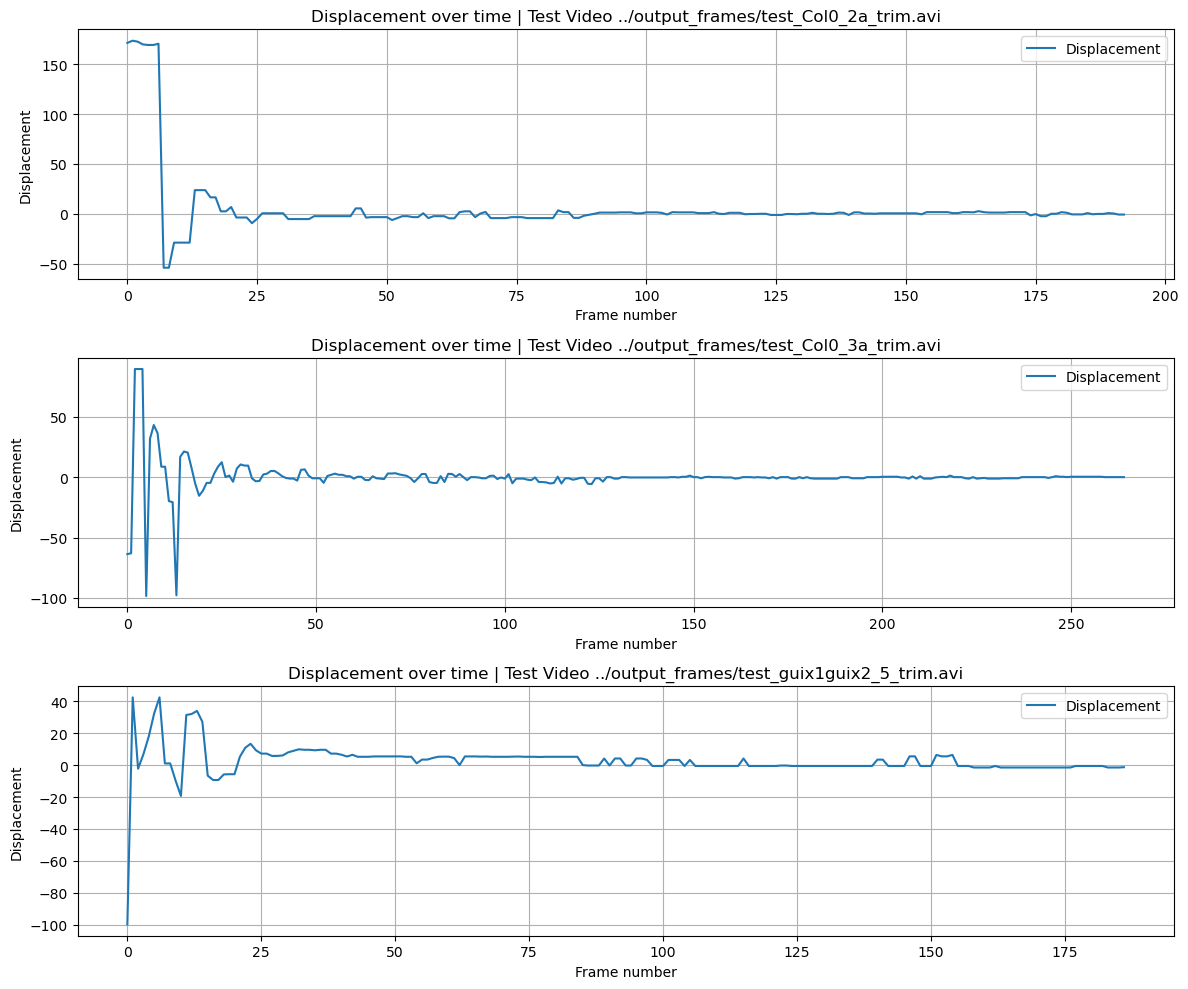

In [23]:
process_thresold_videos(videos,extract_frames,centroids_to_displacements)

In [93]:
centroids = process_video('../output_frames/test_Col0_3a_trim.avi','./test_Col0_3a_trim/marker_augmentation')
displacement = centroids_to_displacements(centroids)


Extracting frames from the video...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (480.384033203125, 430.27203369140625). Marking it on the frame...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (483.1168263753255, 431.26349385579425). Marking it on the frame...
  Matching feature

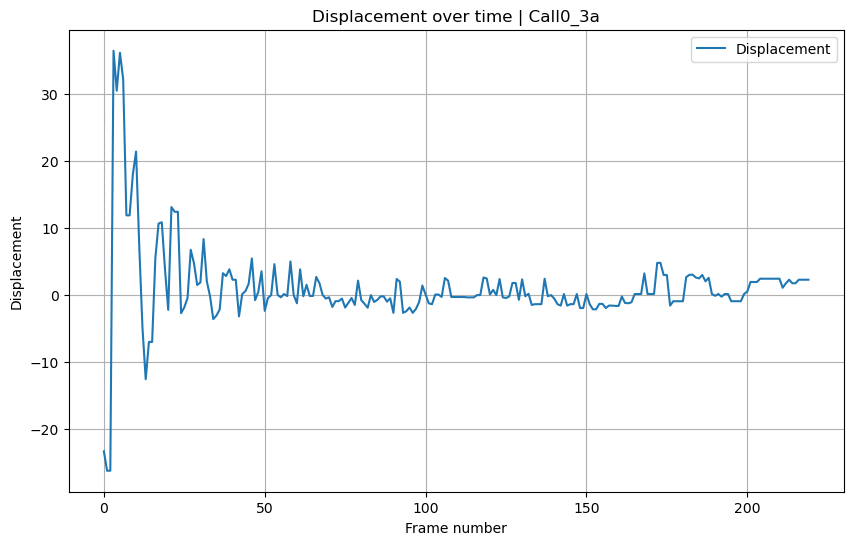

In [94]:
plot_displacement(displacement,'Call0_3a')

In [95]:
centroids = process_video('../output_frames/test_guix1guix2_5_trim.avi','./test_guix1guix2_5_trim/marker_augmentation')
displacement = centroids_to_displacements(centroids)



Extracting frames from the video...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (399.0861511230469, 381.66636149088544). Marking it on the frame...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (544.4727172851562, 421.25477600097656). Marking it on the frame...
  Matching features between current and previous frame...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (576.6560211181641, 436.6440200805664). Marking it on the frame...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (566.3532409667969, 432.07723236083984). Marking it on the fra

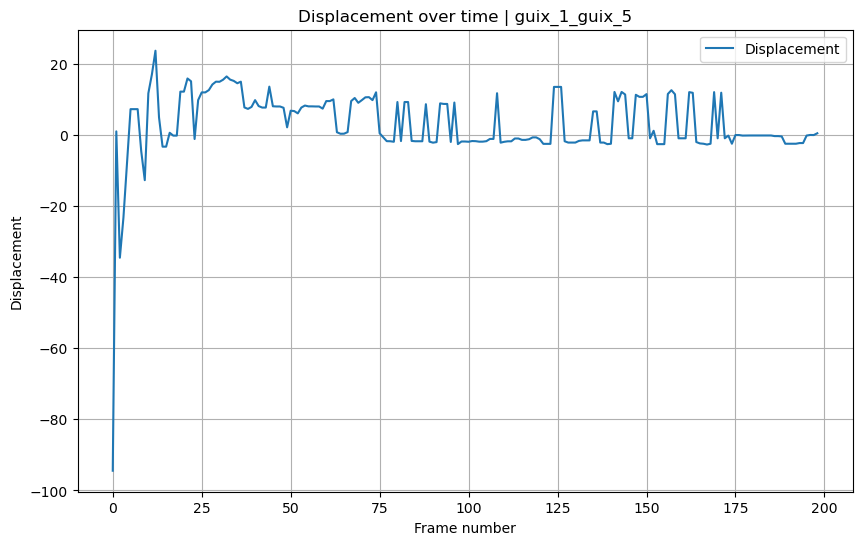

In [96]:
plot_displacement(displacement,'guix_1_guix_5')

In [97]:
centroids = process_video('../output_frames/test_Col0_2a_trim.avi','./test_Col0_2a_trim/marker_augmentation')
displacement = centroids_to_displacements(centroids)

Extracting frames from the video...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (553.3809901646206, 478.82623291015625). Marking it on the frame...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (559.5506998697916, 480.9365539550781). Marking it on the frame...
  Matching features between current and previous frame...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (559.9680582682291, 480.8064371744792). Marking it on the frame...
  Matching features between current and previous frame...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + moving average ...
  New centroid found at (561.6000366210938, 482.112060546875). Marking it on the frame...
  Matching features between current and previous

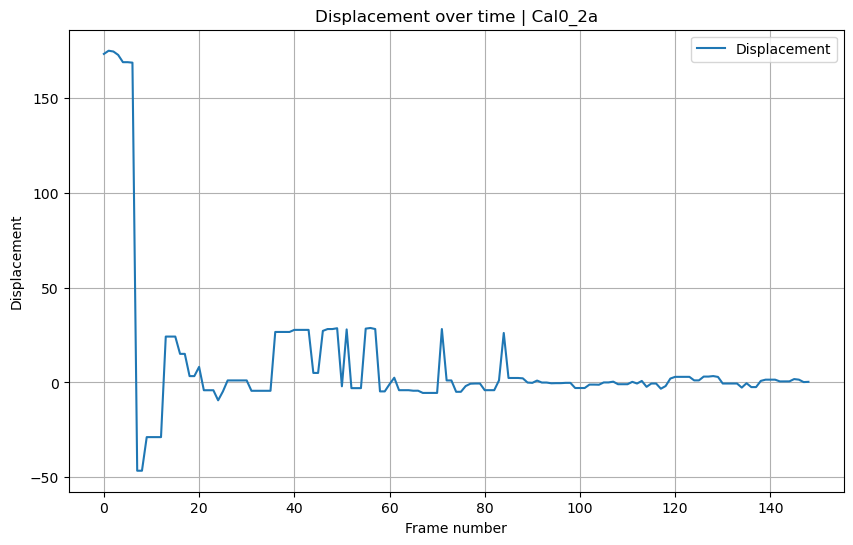

In [98]:
plot_displacement(displacement,'Cal0_2a')

In [103]:
def low_pass_filter(new_value, prev_value, alpha):
    """
    Performs low-pass filtering on the new value.
    """
    return alpha * new_value + (1 - alpha) * prev_value


In [114]:
from sklearn.cluster import DBSCAN

def compute_centroid_with_dbscan(keypoints, eps=3, min_samples=2):
    # Prepare data
    points = np.array([kp.pt for kp in keypoints])

    # Check if keypoints are available
    if len(points) == 0:
        print("No keypoints detected. Returning None as the centroid.")
        return None

    # Apply DBSCAN clustering
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(points)

    # Find the label of the largest cluster
    labels, counts = np.unique(clustering.labels_, return_counts=True)
    largest_cluster_label = labels[np.argmax(counts)]

    # Calculate the centroid of the largest cluster
    largest_cluster_points = points[clustering.labels_ == largest_cluster_label]
    centroid = np.mean(largest_cluster_points, axis=0)
    return centroid

    #return (int(centroid[0]), int(centroid[1]))


In [121]:
from sklearn.linear_model import RANSACRegressor

def compute_centroid_with_ransac(keypoints, residual_threshold=1.0):
    # Prepare data
    points = np.array([kp.pt for kp in keypoints])

    # Check if keypoints are available and there's more than one keypoint
    if len(points) == 0 or len(points) < 2:
        print("Not enough keypoints detected. Returning None as the centroid.")
        return None

    # Apply RANSAC regression
    ransac = RANSACRegressor(residual_threshold=residual_threshold)
    ransac.fit(points[:, 0].reshape(-1, 1), points[:, 1])

    # Select inlier points
    inlier_points = points[ransac.inlier_mask_]

    # Calculate the centroid of the inlier points
    centroid = np.mean(inlier_points, axis=0)
    return centroid



In [122]:
def process_video(video_path, output_folder, centroid_computation_method):
    
    # Extract frames from the video
    print("Extracting frames from the video...")
    frames = extract_frames(video_path)

    # If it doesn't exist, create the output folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Smoothing 
    filtered_centroid = None
    alpha = 0.1  # adjust this value as needed
    
    new_centroid_frames = []
    new_centroids = []
    previous_descriptors = None
    previous_keypoints = None
    
    for i, frame in enumerate(frames):
        #print(f"Processing frame {i+1}/{len(frames)}...")

        centroid, marked_frame = get_red_centroid_threshold(frame, tolerance=0.2)
        if centroid:
            print("  Getting features near the red centroid...")
            keypoints, descriptors = get_features_near_centroid(frame, centroid)
            
            print("  Computing new centroid from the keypoints + smoothing ...")
            if centroid_computation_method == 'mean':
                new_centroid = compute_centroid_of_keypoints(keypoints)
            elif centroid_computation_method == 'dbscan':
                new_centroid = compute_centroid_with_dbscan(keypoints)
            elif centroid_computation_method == 'ransac':
                new_centroid = compute_centroid_with_ransac(keypoints)
            else:
                raise ValueError("Unknown centroid computation method")
        
                
            if new_centroid is not None:
                new_centroids.append(new_centroid)
                
                print(f"  New centroid found at {new_centroid}. Marking it on the frame...")
                new_centroid_frame = cv2.circle(frame.copy(), (int(new_centroid[0]), int(new_centroid[1])), 15, (255, 0, 0), 3)
                new_centroid_frames.append(new_centroid_frame)

            if i > 0 and previous_descriptors is not None and descriptors.size != 0:
                print("  Matching features between current and previous frame...")
                matches = match_features(previous_descriptors, descriptors)

            previous_descriptors = descriptors if descriptors.size != 0 else None
            previous_keypoints = keypoints if descriptors.size != 0 else None

    print("Saving the new centroid frames...")
    save_frames(new_centroid_frames, output_folder)

    print("Done.")
    return new_centroids


In [123]:
process_video('../output_frames/test_Col0_3a_trim.avi','./test_Col0_3a_trim/marker_augmentation_mean', 'mean')
process_video('../output_frames/test_Col0_3a_trim.avi','./test_Col0_3a_trim/marker_augmentation_dbscan', 'dbscan')
process_video('../output_frames/test_Col0_3a_trim.avi','./test_Col0_3a_trim/marker_augmentation_ransac', 'ransac')


Extracting frames from the video...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + smoothing ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + smoothing ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + smoothing ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + smoothing ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + smoothing ...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + smoothing ...
  New centroid found at (480.384033203125, 430.27203369140625). Marking it on the frame...
  Getting features near the red centroid...
  Computing new centroid from the keypoints + smoothing ...
  New centroid found at (483.1168263753255, 431.26349385579425). Marking it on the frame...
  Matching features between current and previous fram

[array([483.11682638, 431.26349386]),
 array([483.11682638, 431.26349386]),
 array([419.67930094, 414.3506368 ]),
 array([428.47710571, 415.15307007]),
 array([422.39238281, 413.66479492]),
 array([415.35049438, 415.35049438]),
 array([395.46266174, 410.15642548]),
 array([395.46266174, 410.15642548]),
 array([401.40414429, 411.64332072]),
 array([404.88588257, 412.28790283]),
 array([378.73756627, 408.27922276]),
 array([389.2082901 , 411.38179016]),
 array([393.12001038, 410.87001038]),
 array([394.1499939 , 412.06591797]),
 array([387.66222127, 408.31788127]),
 array([381.72001648, 410.52001953]),
 array([396.47801971, 411.67601776]),
 array([395.90000916, 410.1000061 ]),
 array([395.40002441, 410.40000916]),
 array([380.91328049, 408.65274811]),
 array([381.90000916, 409.89001465]),
 array([389.00744629, 411.31938171]),
 array([384.89334106, 410.60001628]),
 array([385.80434418, 410.34371948]),
 array([392.36001587, 411.48001099]),
 array([385.51686096, 410.05447388]),
 array([379.

In [14]:
!pip install pykalman

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.9/228.9 kB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pykalman: filename=pykalman-0.9.5-py3-none-any.whl size=48442 sha256=3d0c6d222893d55170a8677e14601b3bd7b9780b9a0d5e21d70db3e1747dce1d
  Stored in directory: /home/benjamin/.cache/pip/wheels/7a/68/21/675239322d2bb2e8e1fa317d4bd7b5566a4e82780b25a27f7a
Successfully built pykalman


In [28]:
import cv2
import numpy as np
from scipy.stats import norm
from sklearn.cluster import DBSCAN
from sklearn.linear_model import RANSACRegressor
from scipy.spatial import ConvexHull
from pykalman import KalmanFilter

def get_red_centroid_threshold(frame, tolerance):
    red_centroids = []
    # Convert the frame to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Split HSV channels
    h, s, v = cv2.split(hsv)

    # Apply CLAHE to improve contrast on the V channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    v = clahe.apply(v)

    # Merge channels back
    hsv = cv2.merge([h, s, v])


    # Define the lower and upper bounds for the red color
    red_color = (200, 142, 143)
    red_hsv = rgb_to_hsv(*red_color)
    lower_red, upper_red = create_hsv_bounds(*red_hsv, tolerance=tolerance)

    # Threshold the HSV image to get only red colors
    mask = cv2.inRange(hsv, lower_red, upper_red)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        # Find the largest contour
        c = max(contours, key=cv2.contourArea)

        # Find the centroid of the largest contour
        M = cv2.moments(c)
        if M["m00"] != 0:  # check for division by zero
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            red_centroids.append((cx, cy))
            
            # Draw a circle on the frame at the centroid
            marked_frame = cv2.circle(frame.copy(), (cx, cy), 15, (0, 255, 0), 3)
            
            return red_centroids, marked_frame

    return red_centroids, frame 


def process_video_filter(video_path, output_folder):
    # If it doesn't exist, create the output folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Initialize the Kalman filter
    kf = KalmanFilter(initial_state_mean=[0, 0, 0, 0],
                      transition_matrices=[[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]])

    cap = cv2.VideoCapture(video_path)

    while(cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            break

        # Get the centroid of the red color in the frame
        centroids, marked_frame = get_red_centroid_threshold(frame, tolerance=30)

        if len(centroids) > 0:
            # Use the Kalman filter to predict and update the centroid
            predicted_centroids = kf.em(centroids).smooth(centroids)[0]

            for centroid in predicted_centroids:
                # Draw a circle on the frame at the predicted centroid
                marked_frame = cv2.circle(marked_frame, (int(centroid[0]), int(centroid[1])), 15, (255, 0, 0), 3)
                break  # only consider the first centroid for simplicity

        # Save the marked frame to the output folder
        print("Saving the new centroid frames...")
        save_frames(marked_frame, output_folder)

    cap.release()


In [29]:
centroids_f = process_video_filter('../output_frames/test_Col0_3a_trim.avi','./test_Col0_3a_trim/kalman_marker')

Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new

In [39]:
def process_video_filter(video_path, output_folder):
    # If it doesn't exist, create the output folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    # Initialize a Kalman filter
    kf = KalmanFilter(transition_matrices=[[1, 0, 1, 0], 
                                           [0, 1, 0, 1], 
                                           [0, 0, 1, 0], 
                                           [0, 0, 0, 1]], 
                      observation_matrices=[[1, 0, 0, 0], 
                                            [0, 1, 0, 0]],
                      initial_state_mean=[0, 0, 0, 0],
                      transition_covariance=np.eye(4),  # you can adjust these parameters
                      observation_covariance=np.eye(2))  # you can adjust these parameters

    # Initial state and covariance
    state = np.array([0, 0, 0, 0])
    state_covariance = np.eye(4)
    
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        # Read a frame from the video
        ret, frame = cap.read()
        if not ret:
            break

        # Get the centroid of the red color in the frame
        centroids, _ = get_red_centroid_threshold(frame, tolerance=0.17)

        if len(centroids) > 0:
            # Use the observed centroid to update the Kalman filter
            state, state_covariance = kf.filter_update(
                state,
                state_covariance,
                observation=centroids[0]
            )

            # Use the estimated state to draw the centroid on the frame
            marked_frame = cv2.circle(frame.copy(), 
                                      (int(state[0]), int(state[1])), 
                                      15, (0, 255, 0), 3)
        else:
            marked_frame = frame
            
        # Save the marked frame to the output folder
        print("Saving the new centroid frames...")
        save_frames(marked_frame, output_folder)
        


In [40]:
centroids_f = process_video_filter('../output_frames/test_Col0_3a_trim.avi','./test_Col0_3a_trim/kalman_marker')


Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new centroid frames...
Saving the new

In [73]:
def compare_methods(video_path, output_folder_base):
    # Extract frames from the video
    frames = extract_frames(video_path)

    # Initialize previous keypoints and descriptors
    previous_descriptors = None
    prev_points = None
    descriptors = None

    # Initialize the previous frame (grayscale)
    prev_gray = None

    for i, frame in enumerate(frames):
        # Get the red centroid
        centroid, marked_frame_threshold = get_red_centroid_threshold(frame, tolerance=0.2)
        # If a centroid was found, use it for both methods
        last_centroid_orb = centroid if centroid else None
        last_centroid_optical_flow = centroid if centroid else None
        prev_points = np.array([centroid[0]], dtype=np.float32) if centroid else None

        # Save the frame with the threshold method
        #save_frames(marked_frame_threshold, f"{output_folder_base}_threshold", i)

        # If no centroid was found, use ORB for estimation
        if last_centroid_orb is not None and previous_descriptors is not None:
            keypoints, descriptors = get_features(frame, last_centroid_orb)
            if i > 0:
                matches = match_features(previous_descriptors, descriptors)
                # If matches were found, find the centroid
                if len(matches) > 0:
                    last_centroid_orb = compute_centroid_from_matches(keypoints, matches)
                marked_frame_orb = cv2.drawKeypoints(frame.copy(), [keypoints[m.queryIdx] for m in matches], None, color=(0, 255, 0), flags=0)
            else:
                marked_frame_orb = frame.copy()
            # Save the frame with the ORB method
            save_frames(marked_frame_orb, f"{output_folder_base}_orb", i)

        # Prepare for the next iteration
        prev_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        previous_descriptors = descriptors

        # If no centroid was found, use optical flow for estimation
        if last_centroid_optical_flow is not None and prev_points is not None and prev_gray is not None:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            new_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_points, None)
            # Find the new centroid from the optical flow
            if status.sum() > 0:
                last_centroid_optical_flow = tuple(new_points[status.reshape(-1) == 1].mean(axis=0))
                marked_frame_optical_flow = cv2.circle(frame.copy(), tuple(map(int, last_centroid_optical_flow)), 15, (0, 255, 0), 3)
            else:
                marked_frame_optical_flow = frame.copy()
            # Save the frame with the optical flow method
            save_frames(marked_frame_optical_flow, f"{output_folder_base}_optical_flow")

        # Prepare for the next iteration
        prev_points = new_points.reshape(-1, 1, 2)
        prev_gray = gray


In [76]:
def get_features(frame, last_centroids=None, radius=20):
    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Create a mask around the last known centroid
    mask = None
    if last_centroids is not None and len(last_centroids) > 0:
        mask = np.zeros_like(gray)
        for last_centroid in last_centroids:
            cv2.circle(mask, tuple(map(int, last_centroid)), radius, 255, -1)  # Draw a white circle at the centroid

    # Detect keypoints and compute the descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, mask)

    return keypoints, descriptors



def get_optical_flow(prev_frame, frame, prev_points):
    # Parameters for Lucas-Kanade optical flow
    lk_params = dict(winSize=(15, 15), maxLevel=2, criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Calculate optical flow (i.e., track feature points)
    curr_points, status, error = cv2.calcOpticalFlowPyrLK(prev_frame, frame, prev_points, None, **lk_params)

    # Only keep points with status == 1
    good_new = curr_points[status == 1]
    good_old = prev_points[status == 1]

    return good_new, good_old

In [77]:
compare_methods('../output_frames/test_Col0_3a_trim.avi','./test_Col0_3a_trim/augmentation_bench')